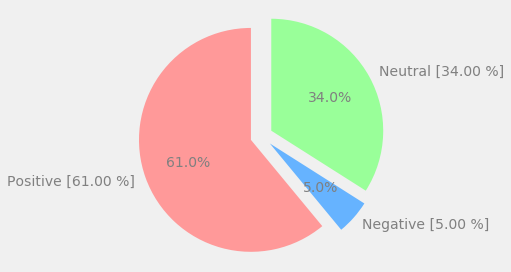

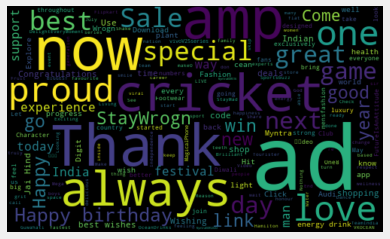

In [1]:
import tkinter as tk
from tkinter import *
from tkinter import ttk
import tkinter.font as tkFont
from PIL import ImageTk,Image
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud as WC
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as mpl
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
import plotly.graph_objects as go
mpl.style.use('fivethirtyeight')

#**********************************************CREDENTIALS****************************************************
csv_file = pd.read_csv('Twitter API Credentials.txt')
api_key = csv_file['info'][0]
api_secret = csv_file['info'][1]
access_token = csv_file['info'][2]
access_token_secret = csv_file['info'][3]

try:
    authenticate = tweepy.OAuthHandler(api_key, api_secret)
    authenticate.set_access_token(access_token, access_token_secret)
    api_obj = tweepy.API(authenticate, wait_on_rate_limit = True)
except:
    error_text = "Error:AUTHENTICATION FAILED"
    label['text'] = error_text
#**********************************************CREDENTIALS****************************************************


#**********************************************GUI************************************************************
HEIGHT = 650
WIDTH = 1000

window = tk.Tk()
window.title("Sentiment Analysis Through Tweets")

window.resizable(width=False, height=False)

#display window
canvas = tk.Canvas(window, height= HEIGHT, width = WIDTH)
canvas.pack()

#Styling
style = ttk.Style()
style.configure("BW.TLabel", foreground="black", background="white")

style1 = ttk.Style()
style1.configure('TButton', font = ("Helvetica", 13, 'bold'), foreground = 'black', bg = "dark turquoise")

#font style
fontSytle = tkFont.Font(family ="Helvetica", size = 13, weight = 'bold')

#Background image
background_image = ImageTk.PhotoImage(Image.open("Twitter-Background.png"))
background_label = tk.Label(window, image = background_image)
background_label.image = background_image
background_label.place(relx = 0, rely =0, relheight = 1, relwidth = 1)

#Search Bar
upper_frame = tk.Frame(window, bg = "sky blue", bd = 5)
upper_frame.place(relx = 0.7, rely = 0.05, relwidth = 0.5, relheight = 0.1, anchor = 'n')

entry = ttk.Entry(upper_frame, font = fontSytle, style = "BW.TLabel")
entry.place(relwidth = 1, relheight = 1)
entry.insert(0, "Enter a #tag or a username")
entry.configure(state = DISABLED)

def onClick(event):
    entry.configure(state = NORMAL)
    entry.delete(0, END)

entry.bind("<Button-1>", onClick)


#Functions for the buttons
#**************************************************USER SENTIMENT ANALYSIS*************************************
def user_sentiment_analysis():
    try:
        if not(not(entry.get() != "Enter a #tag or a username") or not(len(entry.get()) != 0)):
            username = entry.get()
            tweets = api_obj.user_timeline(screen_name = username, count = 100, lang = 'en', tweet_mode = "extended")
            tweets = tweets[0:100]
            tweet_text = "Show the 3 recent tweets: \n"
            i = 1
            for tweet in tweets[0:3]:
                tweet_text += str(i) + ")" + str(tweet.user.screen_name) + "Tweeted: " + str(tweet.full_text[:50]) + "...\n"
                i+=1

            label.config(font = ("Helvetica", 10, 'bold'))
            label['text'] = tweet_text + "\nLOADING THE TWEET WORD CLOUD AND PIE CHART..."


            # Create a dataframe with a column called Tweets

            df = pd.DataFrame([tweet.full_text for tweet in tweets], columns = ['Tweets'])



            # Clean the data(remove hashtags, urls etc)

            def cleanText(text):
                tweet.txt = re.sub("(RT|via)((?:\\b\\W*@\\w+)+)","",text)
                text = re.sub(r"@\w+\s","", text) #remove @
                text = re.sub(r"@[A-Za-z0-9]+", "", text)
                text = re.sub(r"#","",text) #Remove hastags
                text = re.sub(r"RT[\s]+", "", text)
                text = re.sub(r"https?:\/\/\w+\.\w+\.?\/?\w+","",text)
                text = re.sub(r":","",text)
                text = re.sub(r"_","",text)

                return text

            df['Tweets'] = df['Tweets'].apply(cleanText)


            def getsubjectivity(text):
                return TextBlob(text).sentiment.subjectivity

            #Function to get polarirty
            def getpolarity(text):
                return TextBlob(text).sentiment.polarity

            #creating two coloumns:
            df['Subjectivity']= df['Tweets'].apply(getsubjectivity)
            df['Polarity']=df['Tweets'].apply(getpolarity)
            #function for analysis of tweets:

            def getAnalysis(score):
                if score < 0:
                    return 'Negative'
                elif score == 0:
                    return 'Neutral'
                else:
                    return 'Positive'

            df['Analysis']=df['Polarity'].apply(getAnalysis)


            def get_categories(df):
                pos_df = df[df['Analysis'] == 'Positive']
                neg_df = df[df['Analysis'] == 'Negative']
                n_df = df[df['Analysis'] == 'Neutral']
                return (pos_df,neg_df,n_df)

            def percentage(x,y):
                return "{:.2f}".format(100 * len(x)/len(y))

            pos_df, neg_df, n_df = get_categories(df)

            pos_p = percentage(pos_df,df)
            neg_p = percentage(neg_df,df)
            n_p = percentage(n_df,df)

            labels = ['Positive ['+ pos_p +' %]', 'Negative ['+ neg_p +' %]', 'Neutral ['+ n_p +' %]']
            sizes = [pos_p, neg_p, n_p]
            colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
            explode = (0.1,0.1,0.1)
            fig1, ax1 = mpl.subplots()
            patches, texts, autotexts = ax1.pie(sizes, colors = colors,explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
            for text in texts:
                text.set_color('grey')
            for autotext in autotexts:
                autotext.set_color('grey')
            ax1.axis('equal')  
            mpl.tight_layout()
            mpl.pause(2.8)


            allwords = ' '.join( [twts for twts in df['Tweets']])
            wordCloud =WC(width=500,height=300,random_state=21,max_font_size=119).generate(allwords)
            mpl.imshow(wordCloud,interpolation='bilinear')
            mpl.axis("off")
            mpl.pause(2.8)
        else:
            label.config(font = ("helvetica", 14, 'bold'))
            label['text'] = "GUI NOT RESPONDING.\nKINDLY CHECK IF YOU ENTERED A VALID\nUSERNAME"
    except:
        label.config(font = ("helvetica", 14, 'bold'))
        label['text'] = "GUI NOT RESPONDING.\nKINDLY CHECK IF YOU ENTERED A VALID\nUSERNAME"
    
def hashtag_sentiment_analysis():
    label.config(font = ("helvetica", 14, 'bold'))
    
    try:
        if not(not(entry.get() != "Enter a #tag or a username") or not(len(entry.get()) != 0)):
            searchword= entry.get()
            date_since= "2020-10-1"
            tweets=tweepy.Cursor(api_obj.search,q=searchword,lang="en",since=date_since).items(100) 



            tweet_details=[[tweet.text,tweet.user.screen_name,tweet.user.location] for tweet in tweets]



            tweet_df= pd.DataFrame(data=tweet_details,columns=['Text','User',"Location"])


            def cleanText(text):
                text = re.sub(r"@\w+\s","", text) #remove @
                text = re.sub(r"@[A-Za-z0-9]+", "", text)
                text = re.sub(r"#","",text) #Remove hastags
                text = re.sub(r"RT[\s]+", "", text)
                text = re.sub(r"https?:\/\/\w+\.\w+\.?\/?\w+","",text)
                text = re.sub(r":","",text)
                text = re.sub(r"_","",text)

                return text

            tweet_df['Text'] = tweet_df['Text'].apply(cleanText)

            #Clean text
            pd.set_option('max_colwidth',800)


            from geopy.geocoders import Nominatim
            from googletrans import Translator
            translator = Translator(service_urls=[
                'translate.google.com',
                'translate.google.co.kr',
                ])
            translator = Translator()


            def get_country(input):
                try:
                    geolocator = Nominatim(user_agent="SAHBA")
                    geocode_result = geolocator.geocode(input)
                    location_disp = geocode_result.raw
                    country = (location_disp['display_name'].rsplit(',' ,1)[1])
                    country = translator.translate(country)
                    return country.text
                except:
                    country="ERROR"
                    return country

            tweet_df['Country']=tweet_df['Location'].apply(lambda x: "" if(not x.strip())else get_country(x))

            ### Data frame with new frames
            def getSubjectivity(text):
                return TextBlob(text).sentiment.subjectivity
            def getPolarity(text):
                return TextBlob(text).sentiment.polarity

            #Adding new columns
            tweet_df['Subjectivity'] = tweet_df['Text'].apply(getSubjectivity)
            tweet_df['Polarity'] = tweet_df['Text'].apply(getPolarity)

            def getAnalysis(score):
                if score < 0:
                    return 'Negative'
                elif score == 0:
                    return 'Neutral'
                else:
                    return 'Positive'

            tweet_df['Analysis']=tweet_df['Polarity'].apply(getAnalysis)

            def get_categories(tweet_df):
                pos_df = tweet_df[tweet_df['Analysis'] == 'Positive']
                neg_df = tweet_df[tweet_df['Analysis'] == 'Negative']
                n_df = tweet_df[tweet_df['Analysis'] == 'Neutral']
                return (pos_df,neg_df,n_df)

            def percentage(x,y):
                return "{:.2f}".format(100 * len(x)/len(y))

            tweet_df[40:80]

            pos_df, neg_df, n_df = get_categories(tweet_df)

            pos_arr = pos_df["Country"].value_counts()   # arr is a series


            neg_arr = neg_df["Country"].value_counts()   # arr is a series
            neg_arr

            label['text'] = "LOADING WORDCLOUD, PIE CHART AND HEATMAP\nFOR THE HASHTAG #" + entry.get()


            allwords = ' '.join( [tweets for tweets in pos_df['Text']])
            wordCloud =WC(width=500,height=300,random_state=21,max_font_size=119).generate(allwords)
            mpl.title('Positive Tweets Wordcloud')
            mpl.imshow(wordCloud,interpolation='bilinear')
            mpl.axis("off")
            mpl.pause(2.8)


            allwords = ' '.join( [tweets for tweets in neg_df['Text']])
            wordCloud =WC(width=500,height=300,random_state=21,max_font_size=119).generate(allwords)
            mpl.title('Negative Tweets Wordcloud')
            mpl.imshow(wordCloud,interpolation='bilinear')
            mpl.axis("off")
            mpl.pause(2.8)

            pos_p1 = percentage(pos_df,tweet_df)
            neg_p1 = percentage(neg_df,tweet_df)
            labels = ['Positive Tweets %', 'Negative TWEETS %']
            sizes = [pos_p1, neg_p1]
            colors = ['#81E067','#FC7070']
            explode = (0.075,0.075)
            fig1, ax1 = mpl.subplots()
            patches, texts, autotexts = ax1.pie(sizes, colors = colors,explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

            for text in texts:
                text.set_color('grey')

            for autotext in autotexts:
                autotext.set_color('grey')
                ax1.axis('equal')  
                mpl.tight_layout()
                mpl.pause(2.8)

            data = dict(
                type = 'choropleth',
                colorscale = 'Blugrn',
                locations = pos_arr.index,
                locationmode = "country names",
                z = pos_df['Country'].value_counts(),
                text = pos_arr.index,
                colorbar = {'title' : 'TWEETS COUNT'},
            )

            layout = dict(
                title = 'POSITIVE TWEETS HEATMAP',
                geo = dict(projection = {'type':'mercator'})
            )
            choromap = go.Figure(data = [data],layout = layout)
            iplot(choromap,validate=False)
            choromap.show(renderer="plotly_mimetype")


            data = dict(
                type = 'choropleth',
                colorscale = 'Oryel',
                locations = neg_arr.index,
                locationmode = "country names",
                z = neg_df['Country'].value_counts(),
                text = neg_arr.index,
                colorbar = {'title' : 'TWEETS COUNT'},
            )

            layout = dict(
                title = 'NEGATIVE TWEETS HEATMAP',
                geo = dict(projection = {'type':'mercator'})
            )

            choromap = go.Figure(data = [data],layout = layout)
            iplot(choromap,validate=False)
            choromap.show(renderer="plotly_mimetype")
        else:
            label.config(font = ("helvetica", 14, 'bold'))
            label['text'] = "GUI NOT RESPONDING.\nKINDLY CHECK IF YOU ENTERED A VALID\nHASHTAG"
    except:
        label.config(font = ("helvetica", 14, 'bold'))
        label['text'] = "GUI NOT RESPONDING.\nKINDLY CHECK IF YOU ENTERED A VALID\nHASHTAG"
    
def covidSentiments():
    label.config(font = ("Helvetica", 14, 'bold'))
    
    #Reading dataset
    tweet_df = pd.read_csv("Covid19dataset.csv")
    
    def get_categories(tweet_df):
        pos_df = tweet_df[tweet_df['Analysis'] == 'Positive']
        neg_df = tweet_df[tweet_df['Analysis'] == 'Negative']
        n_df = tweet_df[tweet_df['Analysis'] == 'Neutral']
        return (pos_df,neg_df,n_df)
                
    def percentage(x,y):
        return "{:.2f}".format(100 * len(x)/len(y))

    tweet_df[40:80]

    pos_df, neg_df, n_df = get_categories(tweet_df)

    pos_arr = pos_df["Country"].value_counts() 
    pos_arr = pos_arr.drop("Italy")  # arr is a series
    


    neg_arr = neg_df["Country"].value_counts()
    neg_arr = neg_arr.drop("Italy")   # arr is a series
    
    #Loading message
    label['text'] = "LOADING WORDCLOUD, PIE CHART AND HEATMAP\nFOR THE HASHTAG #Corona"


    allwords = ' '.join( [tweets for tweets in pos_df['Text']])
    wordCloud =WC(width=500,height=300,random_state=21,max_font_size=119).generate(allwords)
    mpl.title('Positive Tweets Wordcloud')
    mpl.imshow(wordCloud,interpolation='bilinear')
    mpl.axis("off")
    mpl.pause(2.8)


    allwords = ' '.join( [tweets for tweets in neg_df['Text']])
    wordCloud =WC(width=500,height=300,random_state=21,max_font_size=119).generate(allwords)
    mpl.title('Negative Tweets Wordcloud')
    mpl.imshow(wordCloud,interpolation='bilinear')
    mpl.axis("off")
    mpl.pause(2.8)

    pos_p1 = percentage(pos_df,tweet_df)
    neg_p1 = percentage(neg_df,tweet_df)
    labels = ['Positive Tweets %', 'Negative TWEETS %']
    sizes = [pos_p1, neg_p1]
    colors = ['#81E067','#FC7070']
    explode = (0.075,0.075)
    fig1, ax1 = mpl.subplots()
    patches, texts, autotexts = ax1.pie(sizes, colors = colors,explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax1.axis('equal')  
    mpl.tight_layout()
    mpl.pause(2.8)

    data = dict(
        type = 'choropleth',
        colorscale = 'Blugrn',
        locations = pos_arr.index,
        locationmode = "country names",
        z = pos_df['Country'].value_counts(),
        text = pos_arr.index,
        colorbar = {'title' : 'TWEETS COUNT'},
    )
    
    layout = dict(
        title = 'POSITIVE TWEETS HEATMAP',
        geo = dict(projection = {'type':'mercator'})
    )
    
    choromap = go.Figure(data = [data],layout = layout)
    iplot(choromap,validate=False)
    choromap.show(renderer="plotly_mimetype")

    data = dict(
        type = 'choropleth',
        colorscale = 'Oryel',
        locations = neg_arr.index,
        locationmode = "country names",
        z = neg_df['Country'].value_counts(),
        text = neg_arr.index,
        colorbar = {'title' : 'TWEETS COUNT'},
    )

    layout = dict(
        title = 'NEGATIVE TWEETS HEATMAP',
        geo = dict(projection = {'type':'mercator'})
    )
    
    choromap = go.Figure(data = [data],layout = layout)
    iplot(choromap,validate=False)
    choromap.show(renderer="plotly_mimetype")

def botoMeter():
    try:
        from botometer import Botometer
        import pandas as pd
        import tweepy
        import re
        import matplotlib.pyplot as mpl
        import plotly.graph_objs as go 
        from plotly.offline import init_notebook_mode,iplot,plot
        init_notebook_mode(connected=True)


        
        csv_file = pd.read_csv('Twitter API Credentials.txt')
        api_key = csv_file['info'][0]
        api_secret = csv_file['info'][1]
        access_token = csv_file['info'][2]
        access_token_secret = csv_file['info'][3]

        label.config(font = ("Helvetica", 14, 'bold'))

        rapidapi_key ='f890b41327msh7b63cac1de0c97bp124245jsn4803aa34ca38'

        twitter_app_auth = {
            'consumer_key': api_key,
            'consumer_secret': api_secret,
            'access_token': access_token,
            'access_token_secret': access_token_secret
        }
        botometer_api_url = "https://botometer-pro.p.rapidapi.com"
        botometer = Botometer(
                        wait_on_ratelimit = True,
                        botometer_api_url=botometer_api_url,
                        rapidapi_key = rapidapi_key,
                        **twitter_app_auth)


        #Getting the data from entry label
        if not(not(entry.get() != "Enter a #tag or a username") or not(len(entry.get()) != 0)):
            user = entry.get()

            bot_score = botometer.check_account(user=user)
            bot_score



            overall_score= bot_score['display_scores']['english']['overall']
            remain = 5-overall_score
            overall_score


            if(overall_score>4):
                label_text = "THE PROBABILTY OF THIS USER IS A BOT IS\nMAXIMUM"
            elif(overall_score>3 and overall_score<4):
                label_text = "THE PROBABILITY OF THIS USER IS A BOT IS\nLARGE"
            elif(overall_score>2 and overall_score<3):
                label_text = "THE PROBABILITY OF THIS USER IS A BOT IS\nLOW"
            elif(overall_score<2):
                label_text = "THE PROBAILITY OF THIS USER IS A BOT IS\nMINIMUM"

            #presenting the data on the gui
            label['text'] = label_text + "\n\nLOADING PIE CHART..."

            labels = ['PROBABILITY OF BOT','PROBABILITY OF NORMAL USER']
            sizes = [overall_score,remain]
            colors = ['#FFD700','#7CFC00']
            explode = (0.075,0.075)
            fig1, ax1 = mpl.subplots()
            patches, texts, autotexts = ax1.pie(sizes, colors=colors, labels=labels ,explode=explode, autopct='%1.1f%%', startangle=90)
            for text in texts:
                text.set_color('grey')
            for autotext in autotexts:
                autotext.set_color('grey')
            ax1.axis('equal')  
            mpl.tight_layout()
            mpl.pause(0.01)
        else:
            label.config(font = ("helvetica", 14, 'bold'))
            label['text'] = "GUI NOT RESPONDING.\nKINDLY CHECK IF YOU ENTERED A VALID\nUSERNAME"
    except:
        label.config(font = ("helvetica", 14, 'bold'))
        label['text'] = "GUI NOT RESPONDING.\nKINDLY CHECK IF YOU ENTERED A VALID\nUSERNAME"

def clearInput():
    entry.delete(0, END)

def exitProgram():
    window.destroy()


#Middle frame
middle_frame = tk.Frame(window, bg = "sky blue", bd = 5)
middle_frame.place(relx = 0.7, rely = 0.2, relwidth = 0.5, relheight = 0.2, anchor = 'n')

#Buttons in middle frame
button1 = ttk.Button(middle_frame, text = "User's Tweet Sentiments",command = user_sentiment_analysis, style = 'TButton')
button1.place(relheight = 0.5, relwidth = 0.5)

button2 = ttk.Button(middle_frame, text = "Hastag Sentiments",command =  hashtag_sentiment_analysis, style = 'TButton')
button2.place(relx = 0.5, relheight = 0.5, relwidth = 0.5)

button3 = ttk.Button(middle_frame, text = "Botometer",command =  botoMeter, style = 'TButton')
button3.place(rely = 0.5, relheight = 0.5, relwidth = 0.5)

button4 = ttk.Button(middle_frame, text = "Covid Hastags Sentiments", command =  covidSentiments, style = 'TButton')
button4.place(relx = 0.5, rely = 0.5, relheight = 0.5, relwidth = 0.5)

#Display label
lower_frame = tk.Frame(window, bg = "sky blue", bd = 5)
lower_frame.place(relx = 0.7, rely = 0.45, relwidth= 0.5, relheight=  0.3, anchor = 'n')

label = ttk.Label(lower_frame, font = fontSytle)
label.place(relwidth = 1, relheight = 1)

#Last frame
last_frame = tk.Frame(window, bg = "sky blue", bd = 5)
last_frame.place(relx = 0.7, rely = 0.80, relwidth= 0.5, relheight=  0.1, anchor = 'n')

#Buttons in last frame
button5 = ttk.Button(last_frame, text = "Clear Search Bar",command = clearInput, style = 'TButton')
button5.place(relheight = 1, relwidth = 0.5)

button6 = ttk.Button(last_frame, text = "Exit Program",command = exitProgram, style = 'TButton')
button6.place(relx = 0.5, relheight = 1, relwidth = 0.5)



window.mainloop()